# Calculate wind capacity factors for NEM region using 20min BARRA-C2

In [2]:
# from dask.distributed import Client,LocalCluster
# from dask_jobqueue import PBSCluster
# import sys

# walltime = "00:05:00"
# cores = 1
# memory = str(4 * cores) + "GB"

# cluster = PBSCluster(
#     walltime=str(walltime),
#     cores=cores,
#     memory=str(memory),
#     processes=cores,
#     job_extra_directives=[
#         "-q normal",
#         "-P dt6",
#         "-l ncpus="+str(cores),
#         "-l mem="+str(memory),
#         "-l storage=gdata/xp65+gdata/w42"
#     ],
#     local_directory="$TMPDIR",
#     job_directives_skip=["select"],
#     #python="/g/data/xp65/public/apps/med_conda_scripts/analysis3-25.08.d/bin/python",
#     #job_script_prologue=['module load conda/analysis3-25.08'],
#     log_directory="/scratch/w42/dr6273/tmp/logs"
# )
# cluster.scale(jobs=1)
# client = Client(cluster)

In [3]:
# client

In [57]:
client.close()
cluster.close()

In [4]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [58]:
walltime = "05:00:00"
cores = 24
memory = str(4 * cores) + "GB"

cluster = PBSCluster(
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    processes=cores,
    job_extra_directives=[
        "-q normal",
        "-P dt6",
        "-l ncpus="+str(cores),
        "-l mem="+str(memory),
        "-l storage=gdata/w42+gdata/rt52+gdata/ob53+scratch/w42"
        # "-l storage=gdata/xp65"
    ],
    local_directory="$TMPDIR",
    job_directives_skip=["select"],
    # python="/g/data/xp65/public/apps/med_conda_scripts/analysis3-25.08.d/bin/python",
    # job_script_prologue=['module load conda/analysis3-25.08'],
    log_directory="/scratch/w42/dr6273/tmp/logs"
)

Task exception was never retrieved
future: <Task finished name='Task-312197' coro=<Client._gather.<locals>.wait() done, defined at /g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/client.py:2122> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/client.py", line 2131, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-312198' coro=<Client._gather.<locals>.wait() done, defined at /g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/client.py:2122> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/client.py", line 2131, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-312199' coro=<Client.

In [59]:
cluster.scale(jobs=1)
client = Client(cluster)

In [60]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.122.29:43385,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [66]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

In [67]:
# %cd /g/data/w42/dr6273/work/power_models

# import functions as fn

In [68]:
# %load_ext autoreload
# %autoreload 2

In [69]:
barra_path = "/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/20min/"
write_path = "/scratch/w42/dr6273/BARRA-C2/"

In [70]:
write_path

'/scratch/w42/dr6273/BARRA-C2/'

In [71]:
# Box encompassing NEM REZs
lons = slice(133.5, 153.7)
lats = slice(-43.4, -13.9)

### Compute wind speed

In [72]:
def windspeed(u, v):
    """
    Compute windspeed from u and v
    
    u: array of zonal wind
    v: array of meridional wind
    """
    return np.sqrt(u ** 2 + v ** 2)

In [73]:
def capacity_factor_vdW(W):
    """
    Computes capacity factor from wind speed data.
    
    W: wind speed (m/s)
    """
    W_0 = 3.5 # cut-in speed (m/s)
    W_r = 13 # rated speed
    W_1 = 25 # cut-out speed (m/s)
    
    # Cubic
    c_f = (W ** 3 - W_0 ** 3) / (W_r ** 3 - W_0 ** 3)
    c_f = c_f.where(W >= W_0, 0) # Set values below cut-in to zero
    c_f = c_f.where(W < W_r, 1) # Set values above rated speed to 1
    c_f = c_f.where(W < W_1, 0) # Set values above cut-off to zero
    c_f = c_f.where(W.notnull(), np.nan) # Ensure NaNs are retained
    
    return c_f

In [74]:
def open_barra(fp, lat_slice, lon_slice, lat_name="lat", lon_name="lon"):
    """
    Open multiple files and preprocess to region.
    
    fp: str, path to file. Should not include files, only the path to dir.
    lat_slice, lon_slice: slice of lat/lon to subset
    lat_name, lon_name: names of lat/lon coords.
    """
    def preprocess(ds):
        # ds = ds.rename({lat_name: "lat"})
        # ds = ds.rename({lon_name: "lon"})
        ds = ds.sel(lon=lon_slice, lat=lat_slice)
        # ds["time"] = ds["time"].dt.round(freq="20min")
        return ds.astype("float32")
    
    ds = xr.open_mfdataset(
        fp,
        preprocess=preprocess,
        chunks={"time": "300MB"},# "lat": -1, "lon": -1},
        concat_dim="time",
        combine="nested",
        compat="override",
        coords="minimal",
        data_vars="minimal",
        # decode_times=True
        # parallel=True
    )
    return ds

In [75]:
def get_filename(variable, frequency, year, month):
    """
    Return BARRA-C2 AUST-04 historical data filepaths
    
    variable: str, variable name e.g. ua100m
    frequency: str, timestep e.g. 20min, 1hr
    year: str
    month: str, month in format '01', '02', ..., '12'
    """
    file_template = variable + "_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_" + frequency + "_"
    return barra_path + variable + "/latest/" + file_template + year + month + "-" + year + month + ".nc"

In [76]:
years = range(1979, 2025)
freq = "20min"
height_str = "100m"
month_str = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

In [77]:
# client.restart()

In [78]:
for year in years[:]:
    if year % 5 == 0:
        print(year)
        
    monthly_arrays = []
    for month in month_str[:]:
        
        u = open_barra(
            get_filename("ua"+height_str, freq, str(year), month),
            lats,
            lons
        )
        v = open_barra(
            get_filename("va"+height_str, freq, str(year), month),
            lats,
            lons
        )
        w = windspeed(
            u.rename({"ua"+height_str: "w"+height_str}),
            v.rename({"va"+height_str: "w"+height_str})
        )
        # w = w.chunk({"time": 200, "lat": -1, "lon": -1})
        # w = w.persist()
        
        cf = capacity_factor_vdW(w["w"+height_str])
        
        cf = u.ua100m
        
        # Chunk size of 72 as it is the greatest common divisor of
        #. the different time steps associated with each month
        cf = cf.chunk({"time": 72, "lat": -1, "lon": -1})
        
        cf = cf.to_dataset(name="cf"+height_str)
        
        encoding = {
            "cf"+height_str: {"dtype": "float32"}
        }
        
        if month == "01":
            cf.to_zarr(
                write_path + "derived/wind_capacity_factor/cf" + height_str + "_vdW_BARRA-C2_" + freq + "_" + str(year) + ".zarr",
                mode="w",
                encoding=encoding,
                consolidated=True,
            )
        else:
            cf.to_zarr(
                write_path + "derived/wind_capacity_factor/cf" + height_str + "_vdW_BARRA-C2_" + freq + "_" + str(year) + ".zarr",
                mode="a",
                append_dim="time",
                consolidated=True,
            )

1980
1985
1990
1995
2000
2005
2010
2015
2020


In [89]:
cf1 = xr.open_zarr(
    write_path + "derived/wind_capacity_factor/cf" + height_str + "_vdW_BARRA-C2_" + freq + "_" + str(2022) + ".zarr",
    consolidated=True,
)

In [90]:
cf2 = xr.open_zarr(
    write_path + "derived/wind_capacity_factor/cf" + height_str + "_vdW_BARRA-C2_" + freq + "_" + str(2023) + ".zarr",
    consolidated=True,
)

In [93]:
cf3 = xr.open_zarr(
    write_path + "derived/wind_capacity_factor/cf" + height_str + "_vdW_BARRA-C2_" + freq + "_" + str(2024) + ".zarr",
    consolidated=True,
)

In [94]:
print(len(cf1.time), len(cf2.time), len(cf3.time))

26280 26280 26352


In [97]:
cf1.is.ncount().compute()

<xarray.Dataset> Size: 20B
Dimensions:  ()
Coordinates:
    crs      int32 4B 0
    height   float64 8B 100.0
Data variables:
    cf100m   int64 8B 9800390160

In [ ]:
cf3.isnull().compute()

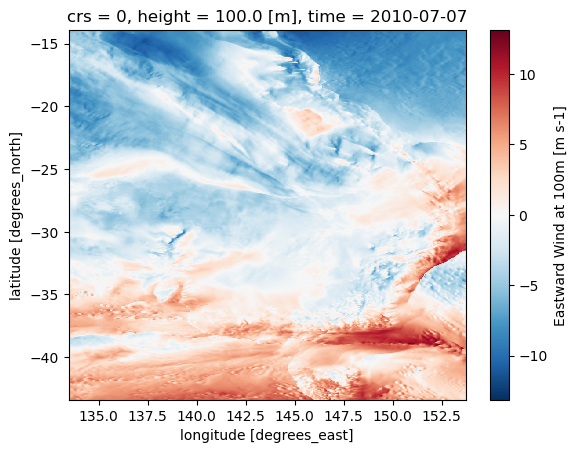

In [85]:
cf.sel(time=slice("2010-07-07", "2010-07-07")).isel(time=0).plot()

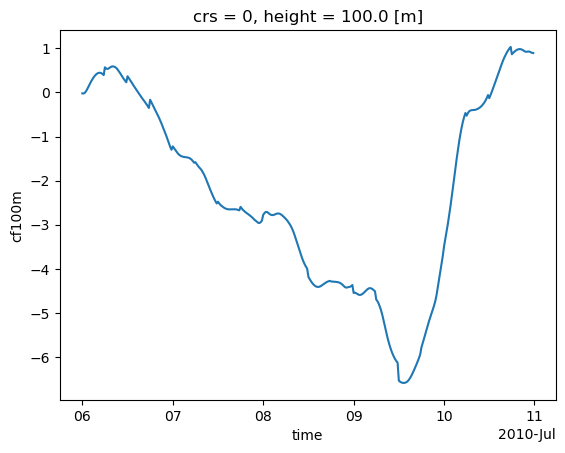

In [88]:
cf.sel(time=slice("2010-07-06", "2010-07-10")).mean(["lat", "lon"]).plot()

In [16]:
years[32:]

range(2011, 2025)

In [17]:
for year in years[32:]:
    if year % 5 == 0:
        print(year)
        
    monthly_arrays = []
    for month in month_str:
        
        u = open_hourly(
            get_filename("ua150m", freq, str(year), month)
        )
        v = open_hourly(
            get_filename("va150m", freq, str(year), month)
        )
        w = windspeed(
            u.rename({"ua150m": "w150m"}),
            v.rename({"va150m": "w150m"})
        )
        w = w.chunk({"time": 3*24*31, "lat": 100, "lon": 100})
                
        encoding = {
            "w150m": {"dtype": "float32"}
        }
        
        if month == "01":
            w.to_zarr(
                write_path + "derived/wind_speed/w150m/w150m_BARRA-C2_" + freq + "_" + str(year) + ".zarr",
                mode="w",
                encoding=encoding,
                consolidated=True,
                # safe_chunks=False
            )
        else:
            w.to_zarr(
                write_path + "derived/wind_speed/w150m/w150m_BARRA-C2_" + freq + "_" + str(year) + ".zarr",
                mode="a",
                append_dim="time",
                consolidated=True,
                # encoding=encoding,
                # safe_chunks=False
            )
        
#     w100 = xr.concat(monthly_arrays, dim="time")
#     w100 = w100.chunk({"time": 3*24*7*6, "lat": 100, "lon": 100})
    
#     encoding = {
#         "w100m": {"dtype": "float32"}
#     }
#     if year == years[0]:
#         w100.to_zarr(
#             write_path + "derived/wind_speed/w100m/w100m_BARRA-C2_" + freq + "_" + str(year) + ".zarr",
#             mode="w",
#             encoding=encoding,
#             consolidated=True,
#             safe_chunks=False
#         )
#     else:
#         w100.to_zarr(
#             write_path + "derived/wind_speed/w100m/w100m_BARRA-C2_" + freq + "_" + str(year) + ".zarr",
#             mode="a",
#             append_dim="time",
#             encoding=encoding,
#             safe_chunks=False
#         )
        

2015
2020


In [72]:
w100 = xr.open_zarr(
    write_path + "derived/wind_speed/w100m/w100m_BARRA-C2_" + freq + "_" + str(year) + ".zarr"
)

In [73]:
w100

<xarray.Dataset> Size: 17GB
Dimensions:  (lat: 875, lon: 1125, time: 4248)
Coordinates:
    crs      int32 4B ...
    height   float64 8B ...
  * lat      (lat) float64 7kB -44.97 -44.93 -44.89 ... -10.09 -10.05 -10.01
  * lon      (lon) float64 9kB 110.0 110.1 110.1 110.1 ... 154.9 154.9 155.0
  * time     (time) datetime64[ns] 34kB 1979-01-01 ... 1979-02-28T23:40:00
Data variables:
    w100m    (time, lat, lon) float32 17GB dask.array<chunksize=(2232, 100, 100), meta=np.ndarray>

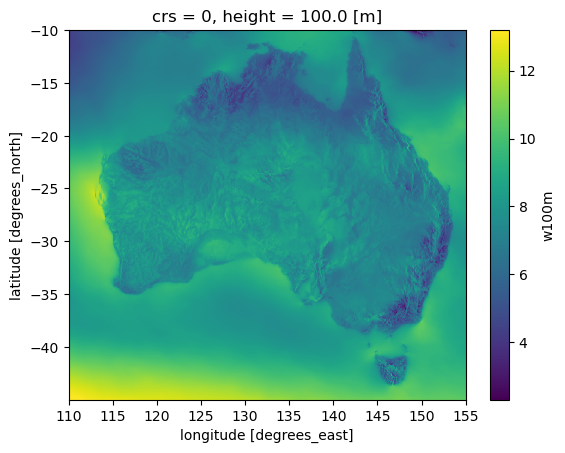

In [23]:
w100.w100m.mean("time").plot()

# Close cluster

In [59]:
client.close()
cluster.close()